# AMV Historical Data

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import math

In [12]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('AMV Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [13]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [14]:
# 4. Chia train. test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [15]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [16]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [17]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [18]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [19]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 10s 207ms/step - loss: 0.0488 - val_loss: 0.0082
Epoch 2/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0094 - val_loss: 0.0029
Epoch 3/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 4/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 5/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 6/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0048 - val_loss: 0.0092
Epoch 7/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0107 - val_loss: 0.0049
Epoch 8/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 9/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 10/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0039 - val_loss: 0.00

In [20]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

8/8 [==============================] - 2s 15ms/step


In [21]:
# 11, Tính toán RMSE, MAPE và MSLE trên tập test

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 437.584
MAPE trên tập test là: 2.6705240830779076 %
MSLE trên tập test là: 0.0009841295


In [22]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.67367446]
206
1 day input [0.41683037 0.42290648 0.42290648 0.43807392 0.42898259 0.42290648
 0.44716524 0.45931747 0.45931747 0.45931747 0.45324135 0.45324135
 0.45022614 0.45022614 0.45022614 0.45022614 0.44716524 0.44415003
 0.42898259 0.45324135 0.45324135 0.45625657 0.45022614 0.44716524
 0.45022614 0.45324135 0.45625657 0.45625657 0.45931747 0.45931747
 0.45324135 0.45625657 0.46233268 0.46233268 0.46539358 0.45324135
 0.44415003 0.43501302 0.43199781 0.42898259 0.4259217  0.40467815
 0.40467815 0.39558682 0.39860204 0.39558682 0.39558682 0.40166294
 0.41075426 0.41075426 0.41381516 0.42898259 0.42290648 0.43807392
 0.43807392 0.44415003 0.45694184 0.46315501 0.47343415 0.47960163
 0.47960163 0.46521084 0.4775458  0.47137832 0.47343415 0.4775458
 0.4775458  0.47960163 0.47548997 0.46726666 0.46315501 0.4384394
 0.4384394  0.44049523 0.44666271 0.44255105 0.44255105 0.44255105
 0.4384394  0.44049523 0.43227192 0.43638357 0.47960163 0.48576911
 0.48576911 0.48165745 0.48576911 0

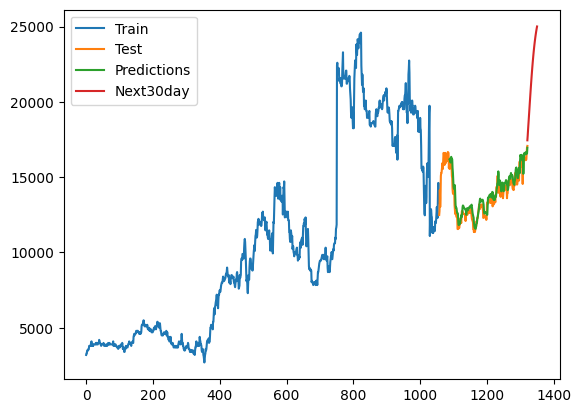

In [23]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DHT Historical Data

In [25]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('DHT Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [26]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [27]:
# 4. Chia train. test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [28]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [31]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [32]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
17/17 [==============================] - 9s 193ms/step - loss: 0.0354 - val_loss: 0.0062
Epoch 2/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 3/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 4/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 5/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 6/100
17/17 [==============================] - 1s 60ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 7/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 8/100
17/17 [==============================] - 1s 59ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 9/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 10/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0017 - val_loss: 0.001

In [33]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

8/8 [==============================] - 3s 43ms/step


In [34]:
# 11, Tính toán RMSE, MAPE và MSLE trên tập test

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 524.8856
MAPE trên tập test là: 3.4366868436336517 %
MSLE trên tập test là: 0.0019192395


In [35]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.11501901]
205
1 day input [0.31588229 0.33059552 0.32896183 0.33713529 0.32569444 0.30444145
 0.31915468 0.31915468 0.30770883 0.32405576 0.30116906 0.3142486
 0.29790168 0.28808953 0.26847522 0.26847522 0.27501499 0.27501499
 0.27501499 0.26683653 0.28318845 0.29953537 0.29626799 0.29953537
 0.30280276 0.29626799 0.29953537 0.25048961 0.24068245 0.23414269
 0.22106315 0.24231615 0.21616207 0.18182954 0.18182954 0.18182954
 0.18509692 0.18673561 0.18509692 0.16875    0.16875    0.18346323
 0.18346323 0.16875    0.190003   0.18673561 0.18509692 0.17038369
 0.1883693  0.1883693  0.19163669 0.19163669 0.19163669 0.19490907
 0.19490907 0.19490907 0.19490907 0.190003   0.19327038 0.19327038
 0.19981015 0.20144884 0.20634992 0.2096223  0.2096223  0.19490907
 0.17365608 0.14586331 0.13605616 0.11970424 0.10335731 0.10172362
 0.09681755 0.09027778 0.0853767  0.07556455 0.08327838 0.05551559
 0.06939948 0.06168565 0.07093825 0.07710831 0.02775779 0.
 0.0092526  0.0092526  0.0092526  0.013878

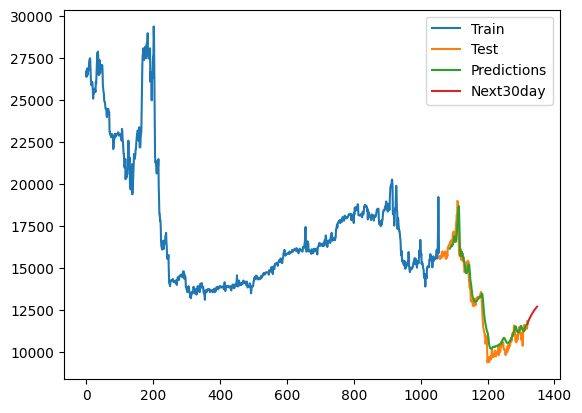

In [36]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DP3 Historical Data

In [44]:
# 2. Đọc file csv và gắng index với giá Close
data = pd.read_csv('DP3 Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [45]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [46]:
# 4. Chia train. test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [47]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [48]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [49]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [50]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [51]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
14/14 [==============================] - 8s 158ms/step - loss: 0.0622 - val_loss: 0.0077
Epoch 2/100
14/14 [==============================] - 1s 73ms/step - loss: 0.0161 - val_loss: 0.0111
Epoch 3/100
14/14 [==============================] - 1s 92ms/step - loss: 0.0111 - val_loss: 0.0037
Epoch 4/100
14/14 [==============================] - 1s 101ms/step - loss: 0.0093 - val_loss: 0.0026
Epoch 5/100
14/14 [==============================] - 1s 103ms/step - loss: 0.0083 - val_loss: 0.0024
Epoch 6/100
14/14 [==============================] - 1s 70ms/step - loss: 0.0078 - val_loss: 0.0023
Epoch 7/100
14/14 [==============================] - 1s 68ms/step - loss: 0.0073 - val_loss: 0.0023
Epoch 8/100
14/14 [==============================] - 1s 65ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 9/100
14/14 [==============================] - 2s 133ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 10/100
14/14 [==============================] - 1s 104ms/step - loss: 0.0059 - val_loss: 0

In [52]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

7/7 [==============================] - 1s 12ms/step


In [53]:
# 11, Tính toán RMSE, MAPE và MSLE trên tập test

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 2066.6145
MAPE trên tập test là: 1.7074348405003548 %
MSLE trên tập test là: 0.0007872845


In [54]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.29301745]
171
1 day input [0.04404404 0.04404404 0.04404404 0.04604605 0.04904905 0.05205205
 0.04704705 0.04704705 0.04704705 0.04404404 0.04404404 0.04904905
 0.04904905 0.04504505 0.04804805 0.05005005 0.05805806 0.05805806
 0.05905906 0.05905906 0.05405405 0.05405405 0.04904905 0.05005005
 0.04904905 0.04704705 0.05405405 0.06406406 0.07407407 0.07207207
 0.07407407 0.04404404 0.03803804 0.04404404 0.04404404 0.04404404
 0.04404404 0.04404404 0.05905906 0.05405405 0.04404404 0.05405405
 0.05405405 0.04904905 0.04404404 0.05405405 0.06106106 0.04404404
 0.04404404 0.04404404 0.04404404 0.04404404 0.04404404 0.04404404
 0.04204204 0.04204204 0.04204204 0.03903904 0.05305305 0.05405405
 0.06206206 0.04604605 0.06306306 0.05405405 0.05105105 0.06406406
 0.04504505 0.04404404 0.03903904 0.03903904 0.03903904 0.03903904
 0.06406406 0.06906907 0.07407407 0.07407407 0.09109109 0.08908909
 0.09409409 0.08508509 0.08408408 0.09409409 0.1001001  0.08408408
 0.08908909 0.0960961  0.10510511

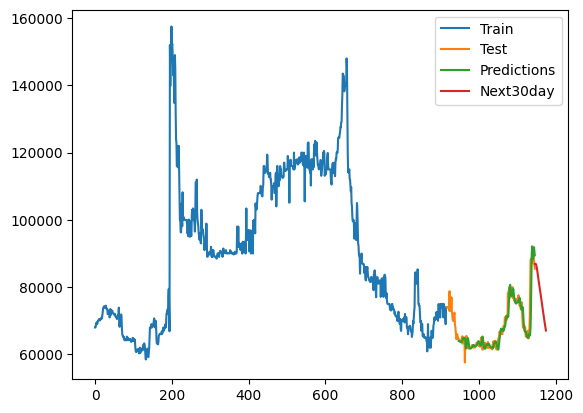

In [55]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()